In [22]:
import sys
sys.path.append('/Users/sbhardwaj/Documents/GraphNodeClassification')

from src.models.models import n2vnet
from src.data.data_loader import DBLP_dataset
from src.utilities.utils import acc , recall
import node2vec
import torch
import os
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Selecting device

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("mps device found")
else:
    device = "cpu"
    print ("MPS device not found.")

mps device found


## Loading unseen data

In [32]:
dataloader_args = {
    "root":os.path.abspath("..") + "/data",
    "raw_filenames":["graph_edges.txt" , "5000_communities.txt"],
    "expt":"edge_sampling",
    "processed_filenames":["data_nc_0.pt" , "data_nc_1.pt" , "data_nc_2.pt" , "data_nc_3.pt" ]
}

dataloader_args

{'root': '/Users/sbhardwaj/Documents/GraphNodeClassification/data',
 'raw_filenames': ['graph_edges.txt', '5000_communities.txt'],
 'expt': 'edge_sampling',
 'processed_filenames': ['data_nc_0.pt',
  'data_nc_1.pt',
  'data_nc_2.pt',
  'data_nc_3.pt']}

In [33]:
d_nc = DBLP_dataset(root = dataloader_args["root"] , raw_filenames = dataloader_args["raw_filenames"] ,
                    expt = "n_communities", processed_filenames = dataloader_args["processed_filenames"])

Processing...
Done!


In [35]:
data = d_nc[2].to(device)
data

Data(x=[15781, 15786], edge_index=[2, 97899], y=[15781, 200], dtype=torch.float32, g=Graph with 15781 nodes and 41059 edges, train_mask=[15781], val_mask=[15781], test_mask=[15781])

In [7]:
d_es = DBLP_dataset(root = dataloader_args["root"] , raw_filenames = dataloader_args["raw_filenames"] ,
                    expt = dataloader_args["expt"], processed_filenames = dataloader_args["processed_filenames"])

In [8]:
data = d_es[0].to(device)
data

Data(x=[33244, 33249], edge_index=[2, 204108], y=[33244, 200], dtype=torch.float32, g=Graph with 33244 nodes and 85432 edges, train_mask=[33244], val_mask=[33244], test_mask=[33244])

## Arguments for Node2Vec embedding generation and model

In [9]:
n2vnet_args = {
    "embedding_dim":16,
    "walk_length":10,
    "num_walks":100,
    "min_count":1,
    "batch_words":5,
    "window":10,

    "hidden_dim":16,
    "num_layers":4,
    "dropout":0.2,

    "lr":0.01,
    "epochs":2000
}

n2vnet_args

{'embedding_dim': 16,
 'walk_length': 10,
 'num_walks': 100,
 'min_count': 1,
 'batch_words': 5,
 'window': 10,
 'hidden_dim': 16,
 'num_layers': 4,
 'dropout': 0.2,
 'lr': 0.01,
 'epochs': 2000}

### Embeddings generation

In [36]:
sorted_node_list = (list(data.g.nodes))
sorted_node_list.sort()
sorted_node_list = [str(node) for node in sorted_node_list]

n2v = node2vec.Node2Vec(data.g , dimensions=n2vnet_args["embedding_dim"] , walk_length=n2vnet_args["walk_length"] , num_walks=n2vnet_args["num_walks"]) 
embeddings = torch.tensor((n2v.fit(window=n2vnet_args["window"] , min_count=n2vnet_args["min_count"] , batch_words=n2vnet_args["batch_words"]).wv)[sorted_node_list] , dtype=torch.float32 , device=device)

Computing transition probabilities:   0%|          | 0/15781 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


### Loading model weights

In [37]:
model_path = "../models/n2vnet_200.pt"

load_n2v_model = n2vnet(data.g , input_dim = n2vnet_args["embedding_dim"], hidden_dim = n2vnet_args["hidden_dim"], output_dim = data.y.shape[1], num_layers = n2vnet_args["num_layers"], dropout = n2vnet_args['dropout']).to(device)
load_n2v_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Testing the output

In [38]:
y = load_n2v_model(embeddings)

In [39]:
c = (multilabel_confusion_matrix((data.y[data.train_mask].int()).cpu() , ((y>0.5)[data.train_mask].int()).cpu()))

In [41]:
acc(np.sum(c , axis=0))

0.9171984158415841

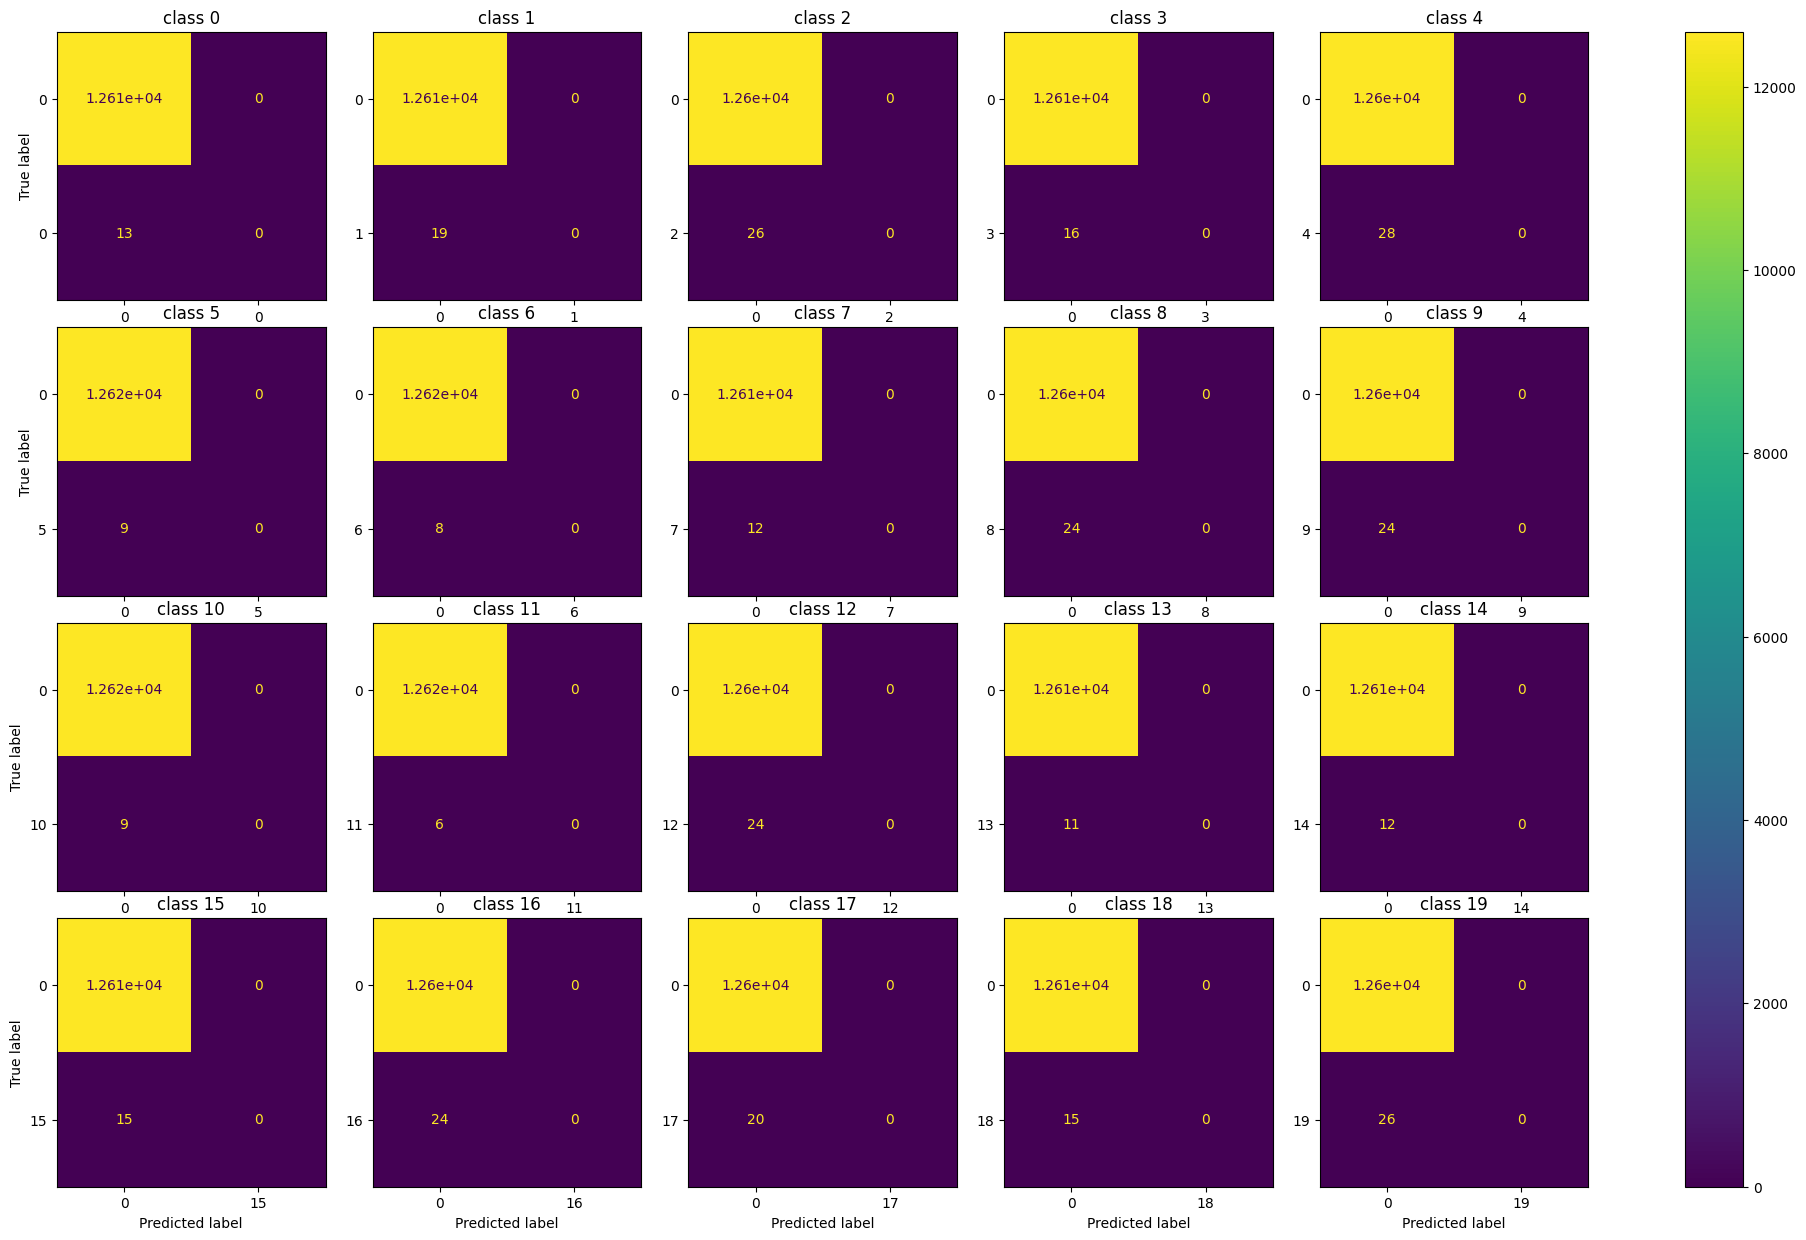

In [42]:
f, axes = plt.subplots(4, 5, figsize=(25, 15))
axes = axes.ravel()

for i in range(20):
    disp = ConfusionMatrixDisplay(c[i] , display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [56]:
((y[0])>0.5).sum()
data.y[55]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='mps:0')